In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import datetime

Using TensorFlow backend.


In [2]:
data = pd.read_csv('dataset/005930.KS_5y.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-10-30,29700.0,30000.0,29680.0,30000.0,41.274914,10588400
1,2013-10-31,29960.0,30040.0,29300.0,29300.0,40.311840,12647050
2,2013-11-01,29800.0,30000.0,29360.0,30000.0,41.274914,11357700
3,2013-11-04,29840.0,30040.0,29780.0,29980.0,41.247398,10887800
4,2013-11-05,30040.0,30040.0,29440.0,29700.0,40.862167,8009300


In [3]:
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices) / 2

In [4]:
seq_len = 50
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [5]:
def normalize_windows(data):
    normalized_data = []
    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
    return np.array(normalized_data)

result = normalize_windows(result)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

((1057, 50, 1), (117, 50, 1))

In [6]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(50, 1)))

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [8]:
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20,
    callbacks=[
        TensorBoard(log_dir='logs/%s' % (start_time)),
        ModelCheckpoint('./models/%s.h5' % (start_time), monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto')
])

Train on 1057 samples, validate on 117 samples
Epoch 1/20
1057/1057 [==============================] - 8s 8ms/step - loss: 6.0914e-04 - val_loss: 2.8894e-04

Epoch 00001: val_loss improved from inf to 0.00029, saving model to ./models/2018_10_30_15_34_51.h5
Epoch 2/20
1057/1057 [==============================] - 8s 8ms/step - loss: 4.9351e-04 - val_loss: 7.7997e-04

Epoch 00002: val_loss did not improve from 0.00029
Epoch 3/20
1057/1057 [==============================] - 8s 8ms/step - loss: 3.8038e-04 - val_loss: 3.1858e-04

Epoch 00003: val_loss did not improve from 0.00029
Epoch 4/20
1057/1057 [==============================] - 9s 9ms/step - loss: 3.1765e-04 - val_loss: 3.6571e-04

Epoch 00004: val_loss did not improve from 0.00029
Epoch 5/20
1057/1057 [==============================] - 9s 8ms/step - loss: 2.6872e-04 - val_loss: 2.2054e-04

Epoch 00005: val_loss improved from 0.00029 to 0.00022, saving model to ./models/2018_10_30_15_34_51.h5
Epoch 6/20
1057/1057 [===================

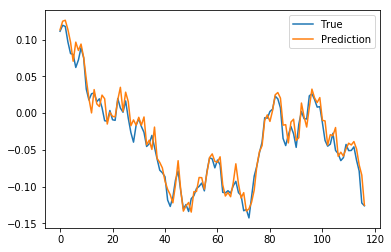

In [9]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()